In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

from sam.utils import convert_number
from sam.gauss_exp import derivatives, get_expectation_functions , compute_grid_weigths, derivatives , get_loss_function, expectation_gauss_hermite
from sam.models import init_teacher_student
from configurations import load_data , make_params_dict, create_fig, set_font_sizes, apply_general_styles , save_fig
from configurations.plot_config import FONTSIZES
apply_general_styles()

from scipy.integrate import odeint , solve_ivp

# Plot simulations


In [7]:
# Parameters
d = 1000                  # Input dimension
tch_act = 'tanh'        # Activation function for teacher
std_act = 'tanh'        # Activation function for student
n_test = 8000           # Number of test samples
bs = 10              # Batch size for training
eps = 0.0               # Noise level for labels
q = 2.0                 # q-norm for SAM
lr = 0.5                # Learning rate


configs = {
    'base': ('SGD',0.0,0.0),
    'sgd': [
            ('SGD',0.00001,0.0),
            ('SGD',0.000001,0.0)
           ],
    'sam': [
            ('SAM',0.0,0.001),
            ('SAM',0.0,0.0001)
           ]
}

# configurations=(
#     'SAM 0.0 0.001'
#     'SAM 0.0 0.0001'
#     'SGD 0.0 0.0'
#     'SGD 0.00001 0.0'
#     'SGD 0.000001 0.0'
# )

summary = {}

for key in configs.keys():
    if key == 'base':
        opt, gamma, rho = configs[key]
        fix_names = ['d','tch_act','std_act','n_test']
        var_names = ['bs','opt','lr','q','rho','gamma']
        params = make_params_dict(fix_names, var_names)
        summary[key] = load_data('first_tests',experiment_name='compare_optimizers', params=params)
    else:
        summary[key] = []
        for i , (opt,gamma,rho) in enumerate(configs[key]):
            fix_names = ['d','tch_act','std_act','n_test']
            var_names = ['bs','opt','lr','q','rho','gamma']
            params = make_params_dict(fix_names, var_names)
            summary[key].append(load_data('first_tests',experiment_name='compare_optimizers', params=params))

step = summary['base']['step']
# for key in summary[i].keys():
#     print(f"{key}: {summary[i][key].shape}")

File first_tests_bs10_gamma0_lr0.5_optSGD_q2_rho0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d1000_n_test8000_std_acttanh_tch_acttanh
File first_tests_bs10_gamma1e-05_lr0.5_optSGD_q2_rho0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d1000_n_test8000_std_acttanh_tch_acttanh
File first_tests_bs10_gamma1e-06_lr0.5_optSGD_q2_rho0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d1000_n_test8000_std_acttanh_tch_acttanh
File first_tests_bs10_gamma0_lr0.5_optSAM_q2_rho0.001.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d1000_n_test8000_std_acttanh_tch_acttanh
File first_tests_bs10_gamma0_lr0.5_optSAM_q2_rho0.0001.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d1000_n_test8000_std_acttanh_tch_acttanh


In [8]:
set_font_sizes(conf='tight')

# Measures to plot
conf_to_plot = {
    'keys' : ['test_loss','overlap','norm2'],
    'titles' : [r'Loss: $\Phi(\boldsymbol{\omega})$',
                r'$M = \frac{1}{d}\;\boldsymbol{\omega}\boldsymbol{\omega}^*$',
                r'$Q = \frac{1}{d}\;\boldsymbol{\omega}\boldsymbol{\omega}$'
               ]
}

settings = {}
for key in configs.keys():
    if key == 'base':
        settings[key] = {'label' : None, 'color' : 'black', 'ls' : '--', 'lw' : 1}
    else:
        settings[key] = []
        n_variations = len(configs[key])
        color_scale = np.linspace(1.0,0.5,n_variations)
        for i , (opt,gamma,rho) in enumerate(configs[key]):
            label = convert_number(gamma) if opt =='SGD' else convert_number(rho)
            cmap = 'Blues' if opt == 'SGD' else 'Oranges'
            color = plt.get_cmap(cmap)(color_scale[i])
            settings[key].append({'label' : label, 'color' : color, 'ls' : '-', 'lw' : 1})

ncols = len(conf_to_plot['keys'])

props = {'fontsize':FONTSIZES['xs'], 'frameon':False,'ncols':1}

# Create figure
fig, axes = create_fig(ncols=ncols, nrows=1, size='double',h=0.15)

# Plot
for i , key in enumerate(conf_to_plot['keys']):
    ax = axes[i]
    ax.set_title(conf_to_plot['titles'][i])
    # Plot Base
    ax.plot(step, summary['base'][key], **settings['base'])
    # Plot Variations
    for ky in ['sgd','sam']:
        for j , sett in enumerate(settings[ky]):
            ax.plot(step, summary[ky][j][key], **sett)


# Personalized Legend
n_sgd = len(settings['sgd'])
handles , labels = ax.get_legend_handles_labels()
handles_sdg , labels_sgd = handles[:n_sgd] , labels[:n_sgd]
fig.legend(handles_sdg, labels_sgd,title=r'$\gamma_{SGD}$', loc=(0.52,0.26),**props)
handles_sam , labels_sam = handles[n_sgd:] , labels[n_sgd:]
fig.legend(handles_sam, labels_sam,title=r'$\rho_{SAM}$', loc=(0.59,0.26), **props)

# ax.set_xscale('log')
for i in [0]:
    ax = axes[i]
    ax.set_yscale('log')


NameError: name 'np' is not defined

# Gaussian Expectations - ODE

In [2]:
tch_act = 'tanh'
std_act = 'tanh'
# Set device and initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
device = torch.device(device)

n=50
grid , weigths = compute_grid_weigths(n,device)
funcs = get_expectation_functions(tch_act,std_act)
loss_function = get_loss_function(tch_act,std_act)



configs = {
    'base': ('SGD',0.0,0.0),
    'sgd': [
            ('SGD',0.001,0.0),
            ('SGD',0.0001,0.0)
           ],
    'sam': [
            ('SAM',0.0,0.01),
            ('SAM',0.0,0.001)
           ]
}

# Initial conditions and fixed parameters
M0 = 0.001
Q0 = 1.0
X0 = np.array([M0, Q0])
times = np.linspace(0, 2000, 200)
lr = 0.05
Q_star = 1.0

# Solve ODEs
ode_sol = {}

for key in configs.keys():
    if key == 'base':
        opt, gamma, rho = configs[key]
        parameters = {'lr': lr, 'gamma': gamma, 'rho': rho, 'Q_star': Q_star}
        result = solve_ivp(derivatives, (times[0], times[-1]), X0,method='Radau', t_eval=times, args=(grid, weigths,funcs,parameters))
        solution = result.y.T
        loss = np.array([expectation_gauss_hermite(loss_function, Q, Q_star, M, grid , weigths) for M, Q in solution])
        ode_sol[key] = {
            'M' : solution[:,0],
            'Q' : solution[:,1],
            'loss' : loss
        }

    else:
        ode_sol[key] = []
        for i , (opt,gamma,rho) in enumerate(configs[key]):
            parameters = {'lr': lr, 'gamma': gamma, 'rho': rho, 'Q_star': Q_star}
            result = solve_ivp(derivatives, (times[0], times[-1]), X0,method='Radau', t_eval=times, args=(grid, weigths,funcs,parameters))
            solution = result.y.T
            loss = np.array([expectation_gauss_hermite(loss_function, Q, Q_star, M, grid , weigths) for M, Q in solution])
            ode_sol[key].append( {
                'M' : solution[:,0],
                'Q' : solution[:,1],
                'loss' : loss
            })


Using device: cuda


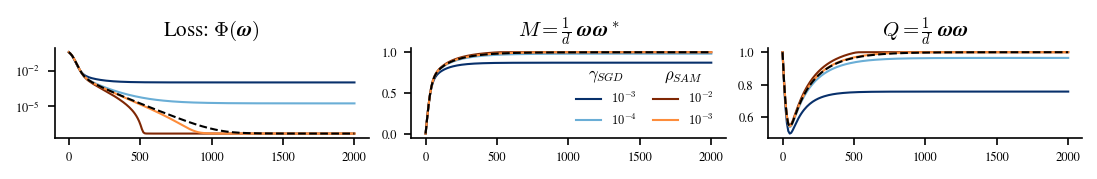

In [87]:
set_font_sizes(conf='tight')

# Measures to plot
conf_to_plot = {
    'keys' : ['loss','M','Q'],
    'titles' : [r'Loss: $\Phi(\boldsymbol{\omega})$',
                r'$M = \frac{1}{d}\;\boldsymbol{\omega}\boldsymbol{\omega}^*$',
                r'$Q = \frac{1}{d}\;\boldsymbol{\omega}\boldsymbol{\omega}$'
               ]
}

settings = {}
for key in configs.keys():
    if key == 'base':
        settings[key] = {'label' : None, 'color' : 'black', 'ls' : '--', 'lw' : 1}
    else:
        settings[key] = []
        n_variations = len(configs[key])
        color_scale = np.linspace(1.0,0.5,n_variations)
        for i , (opt,gamma,rho) in enumerate(configs[key]):
            label = convert_number(gamma) if opt =='SGD' else convert_number(rho)
            cmap = 'Blues' if opt == 'SGD' else 'Oranges'
            color = plt.get_cmap(cmap)(color_scale[i])
            settings[key].append({'label' : label, 'color' : color, 'ls' : '-', 'lw' : 1})

ncols = len(conf_to_plot['keys'])

props = {'fontsize':FONTSIZES['xs'], 'frameon':False,'ncols':1}

# Create figure
fig, axes = create_fig(ncols=ncols, nrows=1, size='double',h=0.15)

# Plot
for i , key in enumerate(conf_to_plot['keys']):
    ax = axes[i]
    ax.set_title(conf_to_plot['titles'][i])
    # Plot Variations
    for ky in ['sgd','sam']:
        for j , sett in enumerate(settings[ky]):
            ax.plot(times, ode_sol[ky][j][key], **sett)
    # Plot Base
    ax.plot(times, ode_sol['base'][key], **settings['base'])


# Personalized Legend
n_sgd = len(settings['sgd'])
handles , labels = ax.get_legend_handles_labels()
handles_sdg , labels_sgd = handles[:n_sgd] , labels[:n_sgd]
fig.legend(handles_sdg, labels_sgd,title=r'$\gamma_{SGD}$', loc=(0.52,0.26),**props)
handles_sam , labels_sam = handles[n_sgd:] , labels[n_sgd:]
fig.legend(handles_sam, labels_sam,title=r'$\rho_{SAM}$', loc=(0.59,0.26), **props)

# ax.set_xscale('log')
for i in [0]:
    ax = axes[i]
    ax.set_yscale('log')


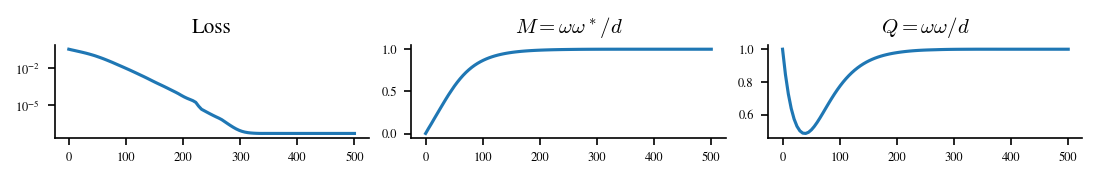

In [33]:
M_sol = solution[:, 0]
Q_sol = solution[:, 1]

set_font_sizes(conf='tight')
fig, axes = create_fig(ncols = 3,size='double',h=0.15)

ax = axes[0]
ax.set_title('Loss')
ax.plot(times, loss)
ax.set_yscale('log')
ax = axes[1]
ax.set_title(r'$M = \omega \omega^*/d$')
ax.plot(times, M_sol)

ax = axes[2]
ax.set_title(r'$Q = \omega \omega/d$')
ax.plot(times, Q_sol)

# ax.set_xscale('log')
# ax.set_xlabel('Time')
# ax.set_ylabel('Values')
# ax.legend()